## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\peteryu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [5, 3]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 4s 70us/step - loss: 1.2331 - acc: 0.5748 - val_loss: 1.4849 - val_acc: 0.4768
Epoch 14/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.2080 - acc: 0.5829 - val_loss: 1.4715 - val_acc: 0.4800
Epoch 15/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.1840 - acc: 0.5908 - val_loss: 1.4670 - val_acc: 0.4822
Epoch 16/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.1603 - acc: 0.5999 - val_loss: 1.4624 - val_acc: 0.4827
Epoch 17/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1359 - acc: 0.6092 - val_loss: 1.4636 - val_acc: 0.4829
Epoch 18/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1144 - acc: 0.6167 - val_loss: 1.4628 - val_acc: 0.4871
Epoch 19/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.0937 - acc: 0.6264 - val_loss: 1.4554 - val_acc: 0.4872
Epoch 20/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 89us/step - loss: 2.4358 - acc: 0.2281 - val_loss: 2.2508 - val_acc: 0.2904
Epoch 2/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.8760 - acc: 0.3566 - val_loss: 1.8946 - val_acc: 0.3646
Epoch 3/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.7280 - acc: 0.4022 - val_loss: 1.7949 - val_acc: 0.3919
Epoch 4/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6501 - acc: 0.4260 - val_loss: 1.7358 - val_acc: 0.4013
Epoch 5/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.5955 - acc: 0.4452 - val_loss: 1.6873 - val_acc: 0.4153
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.5533 - acc: 0.4579 - val_loss: 1.6636 - val_acc: 0.4222
Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.5169 - acc: 0.4709 - val_loss: 1.6299 - val_acc

50000/50000 [==============================] - 4s 72us/step - loss: 0.4584 - acc: 0.8678 - val_loss: 1.5521 - val_acc: 0.5193
Epoch 24/25
50000/50000 [==============================] - 4s 72us/step - loss: 0.4376 - acc: 0.8760 - val_loss: 1.5678 - val_acc: 0.5210
Epoch 25/25
50000/50000 [==============================] - 4s 72us/step - loss: 0.4227 - acc: 0.8826 - val_loss: 1.5728 - val_acc: 0.5197
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer

50000/50000 [==============================] - 4s 72us/step - loss: 1.3840 - acc: 0.5195 - val_loss: 1.5479 - val_acc: 0.4588
Epoch 9/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.3606 - acc: 0.5288 - val_loss: 1.5434 - val_acc: 0.4615
Epoch 10/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.3394 - acc: 0.5361 - val_loss: 1.5317 - val_acc: 0.4636
Epoch 11/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.3185 - acc: 0.5447 - val_loss: 1.5220 - val_acc: 0.4692
Epoch 12/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.3009 - acc: 0.5516 - val_loss: 1.5070 - val_acc: 0.4746
Epoch 13/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2833 - acc: 0.5586 - val_loss: 1.5024 - val_acc: 0.4755
Epoch 14/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2666 - acc: 0.5638 - val_loss: 1.4985 - val_acc: 0.4803
Epoch 15/25
50000/50000 [======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.8038 - acc: 0.3764 - val_loss: 2.1985 - val_acc: 0.2841
Epoch 2/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.5423 - acc: 0.4577 - val_loss: 2.1232 - val_acc: 0.3056
Epoch 3/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4364 - acc: 0.4951 - val_loss: 2.0613 - val_acc: 0.3155
Epoch 4/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3578 - acc: 0.5229 - val_loss: 2.6424 - val_acc: 0.2251
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3058 - acc: 0.5379 - val_loss: 2.3177 - val_acc: 0.2833
Epoch 6/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.2552 - acc: 0.5556 - val_loss: 2.5301 - val_acc: 0.2878
Epoch 7/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.2124 - acc: 0.5730 - val_loss: 2.6093 - val_ac

50000/50000 [==============================] - 3s 70us/step - loss: 0.8069 - acc: 0.7426 - val_loss: 1.3551 - val_acc: 0.5349
Epoch 22/25
50000/50000 [==============================] - 4s 70us/step - loss: 0.8018 - acc: 0.7441 - val_loss: 1.3549 - val_acc: 0.5297
Epoch 23/25
50000/50000 [==============================] - 4s 70us/step - loss: 0.7967 - acc: 0.7467 - val_loss: 1.3528 - val_acc: 0.5300
Epoch 24/25
50000/50000 [==============================] - 3s 70us/step - loss: 0.7922 - acc: 0.7478 - val_loss: 1.3579 - val_acc: 0.5337
Epoch 25/25
50000/50000 [==============================] - 4s 70us/step - loss: 0.7871 - acc: 0.7488 - val_loss: 1.3558 - val_acc: 0.5298
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________

Epoch 9/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.5790 - acc: 0.4510 - val_loss: 1.6998 - val_acc: 0.4155
Epoch 10/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.5506 - acc: 0.4605 - val_loss: 1.6684 - val_acc: 0.4135
Epoch 11/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.5242 - acc: 0.4714 - val_loss: 1.6559 - val_acc: 0.42280 - acc: 0.4
Epoch 12/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.4999 - acc: 0.4821 - val_loss: 1.6389 - val_acc: 0.4251
Epoch 13/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4779 - acc: 0.4872 - val_loss: 1.6243 - val_acc: 0.4373
Epoch 14/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4553 - acc: 0.4968 - val_loss: 1.6187 - val_acc: 0.4418
Epoch 15/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.4370 - acc: 0.5027 - val_loss: 1.6097 - val_acc: 0.4414
Epoch 16/25
50000/50000

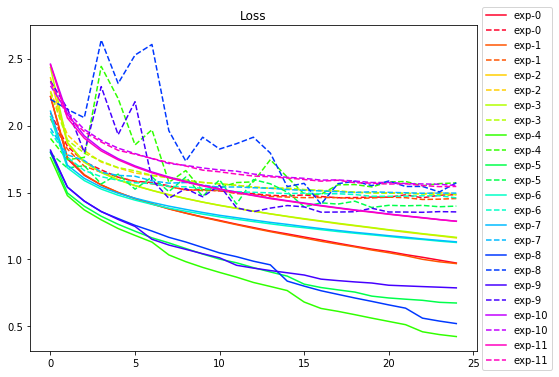

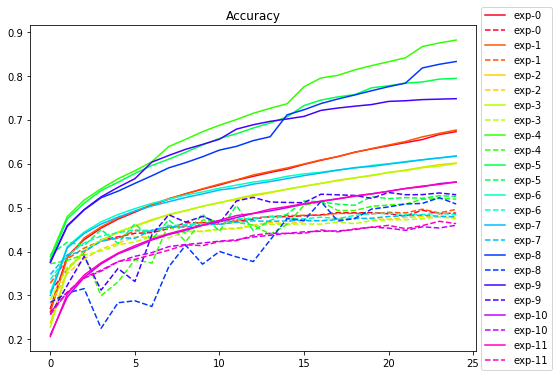

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()